In [1]:
# importing libs
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import openpyxl
from openpyxl.reader.excel import load_workbook
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout,Add,Concatenate
from keras.models import Model
from keras.constraints import max_norm
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD
from keras import backend as K
from google.colab import files

In [2]:
# for reproducing result
tf.random.set_seed(3)

In [3]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (7,4) autoencoder n_channel = 7 and M = 2^4 = 16 
M = 16
k = np.log2(M)
k = int(k)
n_channel = 2
R = k/n_channel
max_val=1
print ('M:',M,'k:',k,'n:',n_channel)
prop=250

M: 16 k: 4 n: 2


In [4]:
#generating data of size N
N = 1000000
label = np.random.randint(M,size=N)

In [5]:
# creating one hot encoded vectors
data=np.zeros([N,M])
for i in range(len(label)):
    data[i][label[i]] = 1


EbNo_train = 10 #  coverted 7 db of EbNo
noise=np.random.normal(0,np.sqrt(1/(2*R*EbNo_train)),[N,n_channel])

In [15]:
''' a custom activation function for amplitude constraint (~QAM style)'''
def mapping_to_target_range( x, target_min=-np.sqrt(max_val), target_max=np.sqrt(max_val) ) :
    x02 = K.tanh(x)+1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

'''a custom loss function for the average power constraint (~unique result)'''
def custom_loss(signal):
    def loss(y_true, y_pred):
        sqsig=tf.math.square(signal)
        bound=tf.convert_to_tensor(max_val, dtype=float)
        sigenergy=tf.convert_to_tensor(tf.math.reduce_sum(sqsig),float)
        # sloss = tf.keras.backend.switch(tf.math.greater((tf.keras.backend.sum(tf.keras.backend.square(signal))),tf.keras.backend.constant(max_val)),tf.keras.backend.sum(tf.keras.backend.square(signal))-tf.keras.backend.constant(max_val),tf.keras.backend.constant(0))
        # return sloss/prop+keras.losses.categorical_crossentropy(y_true, y_pred)
        # sloss = tf.(tf.math.square(signal))-tf.convert_to_tensor(max_val) if tf.keras.metrics.Sum(tf.math.square(signal)) > tf.convert_to_tensor(max_val) else tf.convert_to_tensor(0)
        return sigenergy+tf.convert_to_tensor(max_val, dtype=float) + keras.losses.categorical_crossentropy(y_true, y_pred)
    return loss

# defining autoencoder and its layer
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
# encoded2 = Dense(n_channel, activation='relu')(encoded1) #average power
# encoded2 = Dense(n_channel, activation=mapping_to_target_range)(encoded1) #QAM style
''' an activation function for energy constraint (~PSK style)'''
encoded2 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded1) #only implement for the energy constraint

inputnoise = Input(shape=(n_channel,))
encoded3 = Add()([inputnoise,encoded2])

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model([input_signal,inputnoise], decoded1)
adam = Adam(learning_rate=0.001)
# autoencoder.compile(optimizer=adam, loss=custom_loss(encoded2)) #only implement for average power constraint
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy') #loss for every other constraint
# autoencoder summary
print (autoencoder.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 16)           272         ['input_4[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 2)            34          ['dense_5[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 2)]          0           []                               
                                                                                            

In [16]:
# traning the autoencoder
# autoencoder.fit([data,noise], data, epochs=100, batch_size=M*128)
# autoencoder.fit(data, data, epochs=20, batch_size=M*32)
autoencoder.fit([data, noise], data, epochs=3, batch_size=M*1)
autoencoder.fit([data, noise], data, epochs=25, batch_size=M*16)
autoencoder.fit([data,noise], data, epochs=50, batch_size=M*256)

Epoch 1/3
62500/62500 [==============================] - 115s 2ms/step - loss: 0.2674
Epoch 2/3
62500/62500 [==============================] - 113s 2ms/step - loss: 0.2190
Epoch 3/3
62500/62500 [==============================] - 113s 2ms/step - loss: 0.2177
Epoch 1/25
3907/3907 [==============================] - 12s 3ms/step - loss: 0.2106
Epoch 2/25
3907/3907 [==============================] - 12s 3ms/step - loss: 0.2111
Epoch 3/25
3907/3907 [==============================] - 12s 3ms/step - loss: 0.2111
Epoch 4/25
3907/3907 [==============================] - 11s 3ms/step - loss: 0.2111
Epoch 5/25
3907/3907 [==============================] - 11s 3ms/step - loss: 0.2111
Epoch 6/25
3907/3907 [==============================] - 11s 3ms/step - loss: 0.2110
Epoch 7/25
3907/3907 [==============================] - 11s 3ms/step - loss: 0.2110
Epoch 8/25
3907/3907 [==============================] - 11s 3ms/step - loss: 0.2110
Epoch 9/25
3907/3907 [==============================] - 11s 3ms/step -

In [17]:
# isolating the encoder section from full autoencoder
encoder = Model([input_signal,inputnoise], encoded3)

In [18]:
# isolating the decoder section from full autoencoder
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [19]:
# Making test data
Ntest = 50000
test_label = np.random.randint(M,size=Ntest)
test_data=np.zeros([Ntest,M])
for i in range(len(test_label)):
    test_data[i][label[i]] = 1

In [20]:
# for plotting learned constallation diagram
scatter_plot = []
scatter_plot_nn = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict([np.expand_dims(temp,axis=0),np.random.normal(0,np.sqrt(1/(2*R*EbNo_train)),[1,2])]))
    scatter_plot_nn.append(encoder.predict([np.expand_dims(temp,axis=0),np.random.normal(0,0.01,[1,2])]))
    # print(np.expand_dims(temp,axis=0).shape)
scatter_plot = np.array(scatter_plot)
scatter_plot_nn = np.array(scatter_plot_nn)
print(scatter_plot.shape)
print(scatter_plot_nn.shape)

(16, 1, 2)
(16, 1, 2)


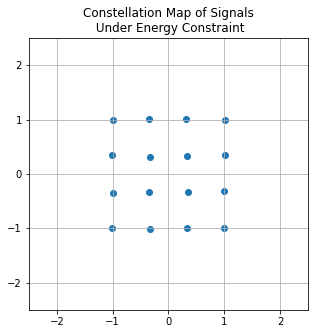

In [14]:
# # plotting constellation diagram
# import matplotlib.pyplot as plt
# plt.figure(figsize=(5, 5))
# plt.title("Constellation Map of Signals\n Under Energy Constraint")
# scatter_plot = scatter_plot.reshape(M,2,1)
# plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
# plt.axis((-2.5,2.5,-2.5,2.5))
# plt.grid()
'''Amplitude Constraint'''
# plotting constellation diagram with noise
plt.figure(figsize=(5, 5))
plt.title("Constellation Map of Signals\n Under Energy Constraint")
scatter_plot_nn = scatter_plot_nn.reshape(M,2,1)
plt.scatter(scatter_plot_nn[:,0],scatter_plot_nn[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()

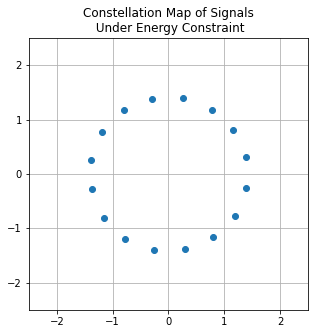

In [21]:
'''Energy Constraint'''
# plotting constellation diagram with noise
plt.figure(figsize=(5, 5))
plt.title("Constellation Map of Signals\n Under Energy Constraint")
scatter_plot_nn = scatter_plot_nn.reshape(M,2,1)
plt.scatter(scatter_plot_nn[:,0],scatter_plot_nn[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()